# Simulate some data to test the method.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm, trange

plotpar = {'axes.labelsize': 25,
           'font.size': 25,
           'legend.fontsize': 25,
           'xtick.labelsize': 25,
           'ytick.labelsize': 25,
           'text.usetex': True}
plt.rcParams.update(plotpar)

import read_mist_models
from isochrones.mist import MIST_Isochrone
from isochrones import StarModel

from stardate.lhf import gyro_model_rossby, gyro_model, age_model, sigma, calc_rossby_number

bands = ["B", "V", "J", "H", "K", "BP", "RP"]
mist = MIST_Isochrone(bands)
mist.initialize()

Draw randomly from mass, age, metallicity, distance and extinction distributions. Use isochrones model to predict $T_\mathrm{eff}$, observed metallicity, $\hat{F}$, apparent magnitudes $J$, $H$, $K$, $B$, $V$, $\log(g)$ and parallax. Use Gyrochronology model to predict rotation period from age and $B$-$V$ color.

In [ ]:
np.random.seed(42)
N = 1000000
eep, eep_err = np.random.uniform(195, 480, size=N), np.ones(N)*10
age = np.log10(np.random.uniform(.5, 14, size=N)*1e9)
age_err = age*.2
feh, feh_err = np.random.uniform(-.2, .2, size=N), np.ones(N)*.01
# mass = mist.mass(eep, age, feh)
mass = mist.interp_value([eep, age, feh], ["mass"])
d_kpc = np.random.uniform(.01, 1, size=N)
dkpc_err = d_kpc*.1
d_pc = d_kpc*1e3
dpc_err = d_pc*.1
av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01

# N = 1000
# eep, eep_err = np.random.uniform(250, 320, size=N), np.ones(N)*10
# age = np.log10(np.random.uniform(1, 3, size=N)*1e9)
# age_err = age*.2
# feh, feh_err = np.random.randn(N)*.01, np.ones(N)*.01
# mass = mist.mass(eep, age, feh)
# d_kpc = np.random.uniform(.01, 1, size=N)
# dkpc_err = d_kpc*.1
# d_pc = d_kpc*1e3
# dpc_err = d_pc*.1
# av, av_err = np.random.uniform(0, .1, size=N), np.ones(N)*.01

def model_grid(eep, eep_err, age, age_err, feh, feh_err, d_kpc, dkpc_err, av, av_err):
    mass = mist.interp_value([eep, age, feh], ["mass"])

    # Save as a pandas data frame
    df = pd.DataFrame(dict({"eep": eep, "eep_err": eep_err,
                            "age": age, "age_err": age_err,
                            "feh": feh, "feh_err": feh_err,
                            "d_kpc": d_kpc, "dkpc_err": dkpc_err,
                            "Av": av, "Av_err": av_err}))
    
    logg, teff, feh_interp, B, V, J, H, K, bp, rp, logL = [np.zeros(len(eep)) for i in range(11)]
    for i in trange(len(eep)):
        teff[i], logg[i], feh_interp[i], bands = mist.interp_mag(
            [eep[i], age[i], feh[i], d_kpc[i]*1e-3, av[i]], 
            ["B", "V", "J", "H", "K", "BP", "RP"])
        B[i], V[i], J[i], H[i], K[i], bp[i], rp[i] = bands
        logL[i] = mist.interp_value([eep[i], age[i], feh[i]], ["logL"])[0]
    
    df["BV"], df["B"], df["V"], df["jmag"], df["hmag"], df["kmag"], df["bp"], df["rp"] = B - V, \
        B, V, J, H, K, bp, rp
    df["logg"], df["teff"], df["logL"], df["parallax"] = logg, teff, logL, 1./d_kpc
    df["mass"] = mist.mass(df.eep, df.age, df.feh)
    
    return df

df = model_grid(eep, eep_err, age, age_err, feh, feh_err, d_pc, dpc_err, av, av_err)

# _N = 10000
# _eep, _eep_err = np.random.uniform(195, 480, size=_N), np.ones(_N)*10
# _age = np.log10(np.random.uniform(.5, 14, size=_N)*1e9)
# _age_err = _age*.2
# _feh, _feh_err = np.random.uniform(-.2, .2, size=_N), np.ones(_N)*.01
# _d_kpc = np.random.uniform(.01, 1, size=_N)
# _dkpc_err = _d_kpc*.1
# _av, _av_err = np.random.uniform(0, .1, size=_N), np.ones(_N)*.01

# df_grid = model_grid(_eep, _eep_err, _age, _age_err, _feh, _feh_err, _d_kpc, _dkpc_err, _av, _av_err)

Plot the simulated data on an HR diagram.

Text(0, 0.5, '$\\log(g)$')

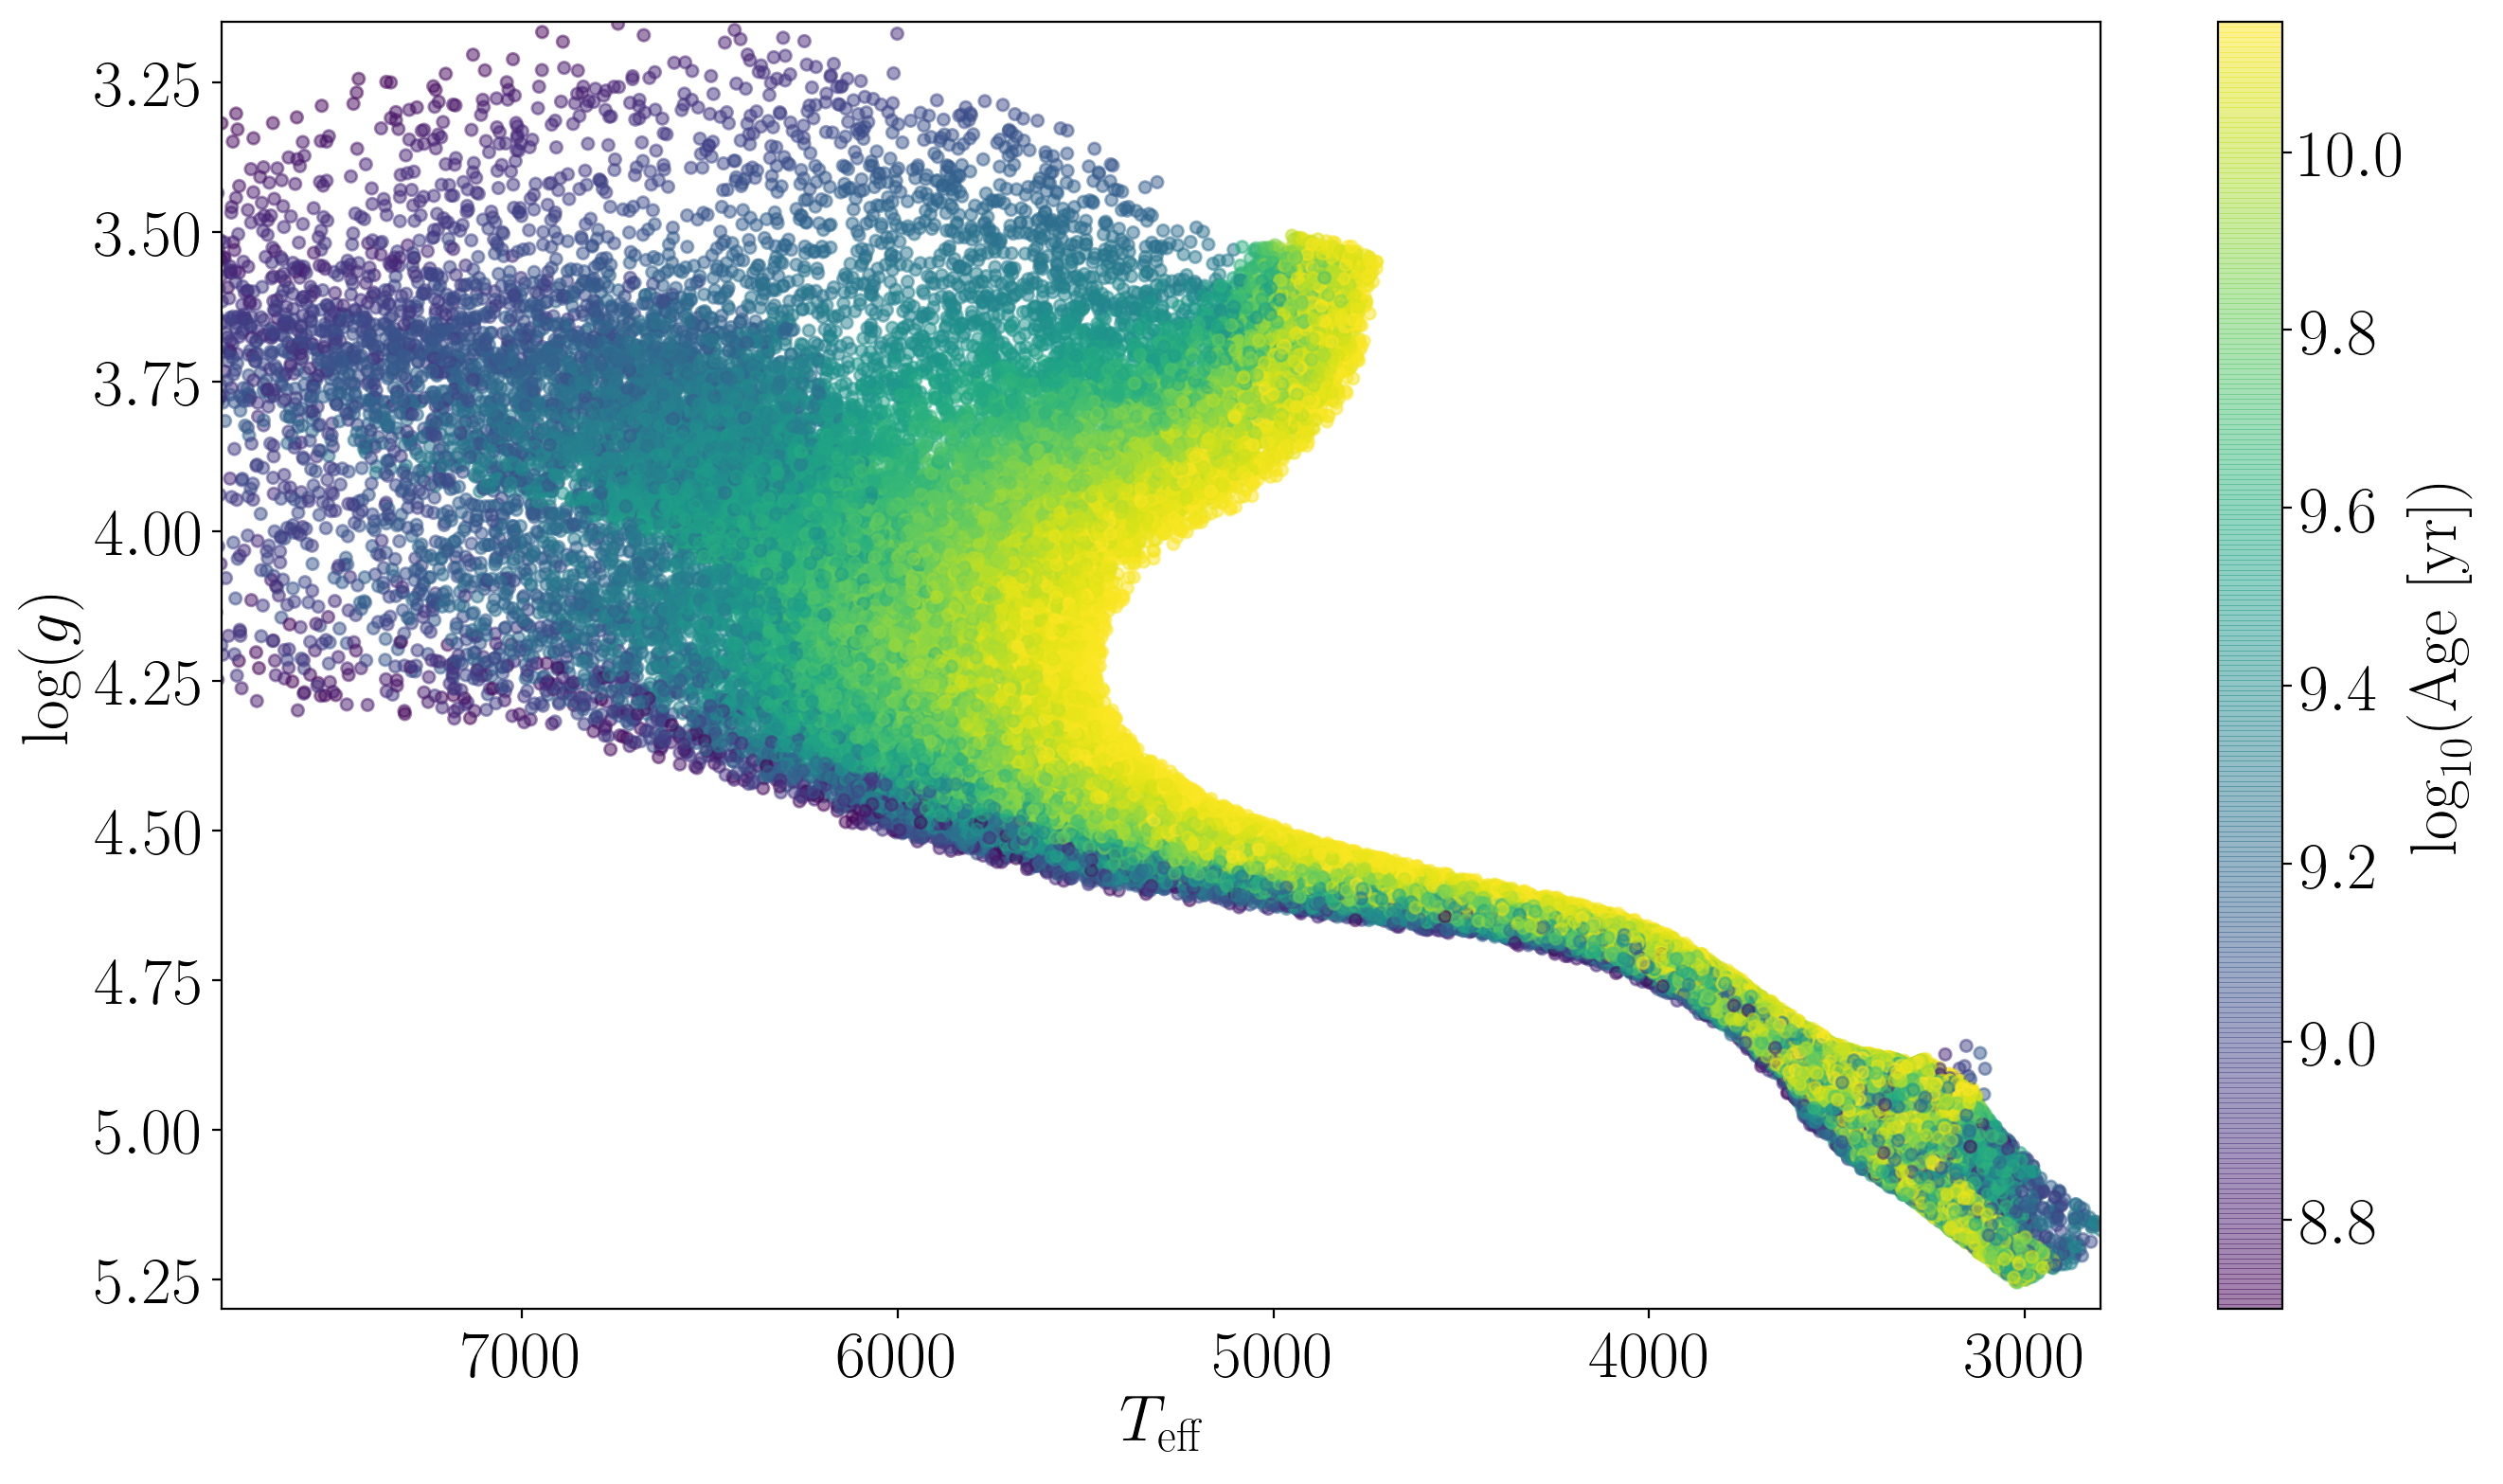

In [3]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.teff, df.logg, c=df.age, s=20, alpha=.5)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlim(7800, 2800)
plt.ylim(5.3, 3.15)
plt.xlabel("$T_{\mathrm{eff}}$")
plt.ylabel("$\log(g)$")

Now calculate the rotation periods of these stars from their ages and BP-RP colours.

In [35]:
# Calculate periods.
log_prot, prot_err = [np.empty(N) for i in range(2)]
period_uncertainty = .05
for i in range(N):
    log_prot[i] = gyro_model_rossby(df.age.values[i], 
                                    np.log10(df.bp.values[i] - df.rp.values[i]),
                                    df.mass.values[i], Ro_cutoff=1.5)
    prot_err[i] = (10**log_prot[i])*period_uncertainty

# Add variance to these.
sig = sigma(np.log10(df.bp.values - df.rp.values), df.eep.values)
log_prot_scatter = log_prot + np.random.randn(len(log_prot))*sig

df["prot"] = 10**log_prot_scatter
df["prot_clean"] = 10**log_prot
df["prot_err"] = prot_err
df["Ro"] = calc_rossby_number(df.prot, df.mass)

# Cut unphysical masses
finite_mask = np.isfinite(df.mass.values)
finite_df = df.iloc[finite_mask]
print(len(df.mass.values), "stars originally, ", len(df.mass.values[finite_mask]), "after cuts")

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log10
  


100000 stars originally,  85712 after cuts


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


(0, 3.5)

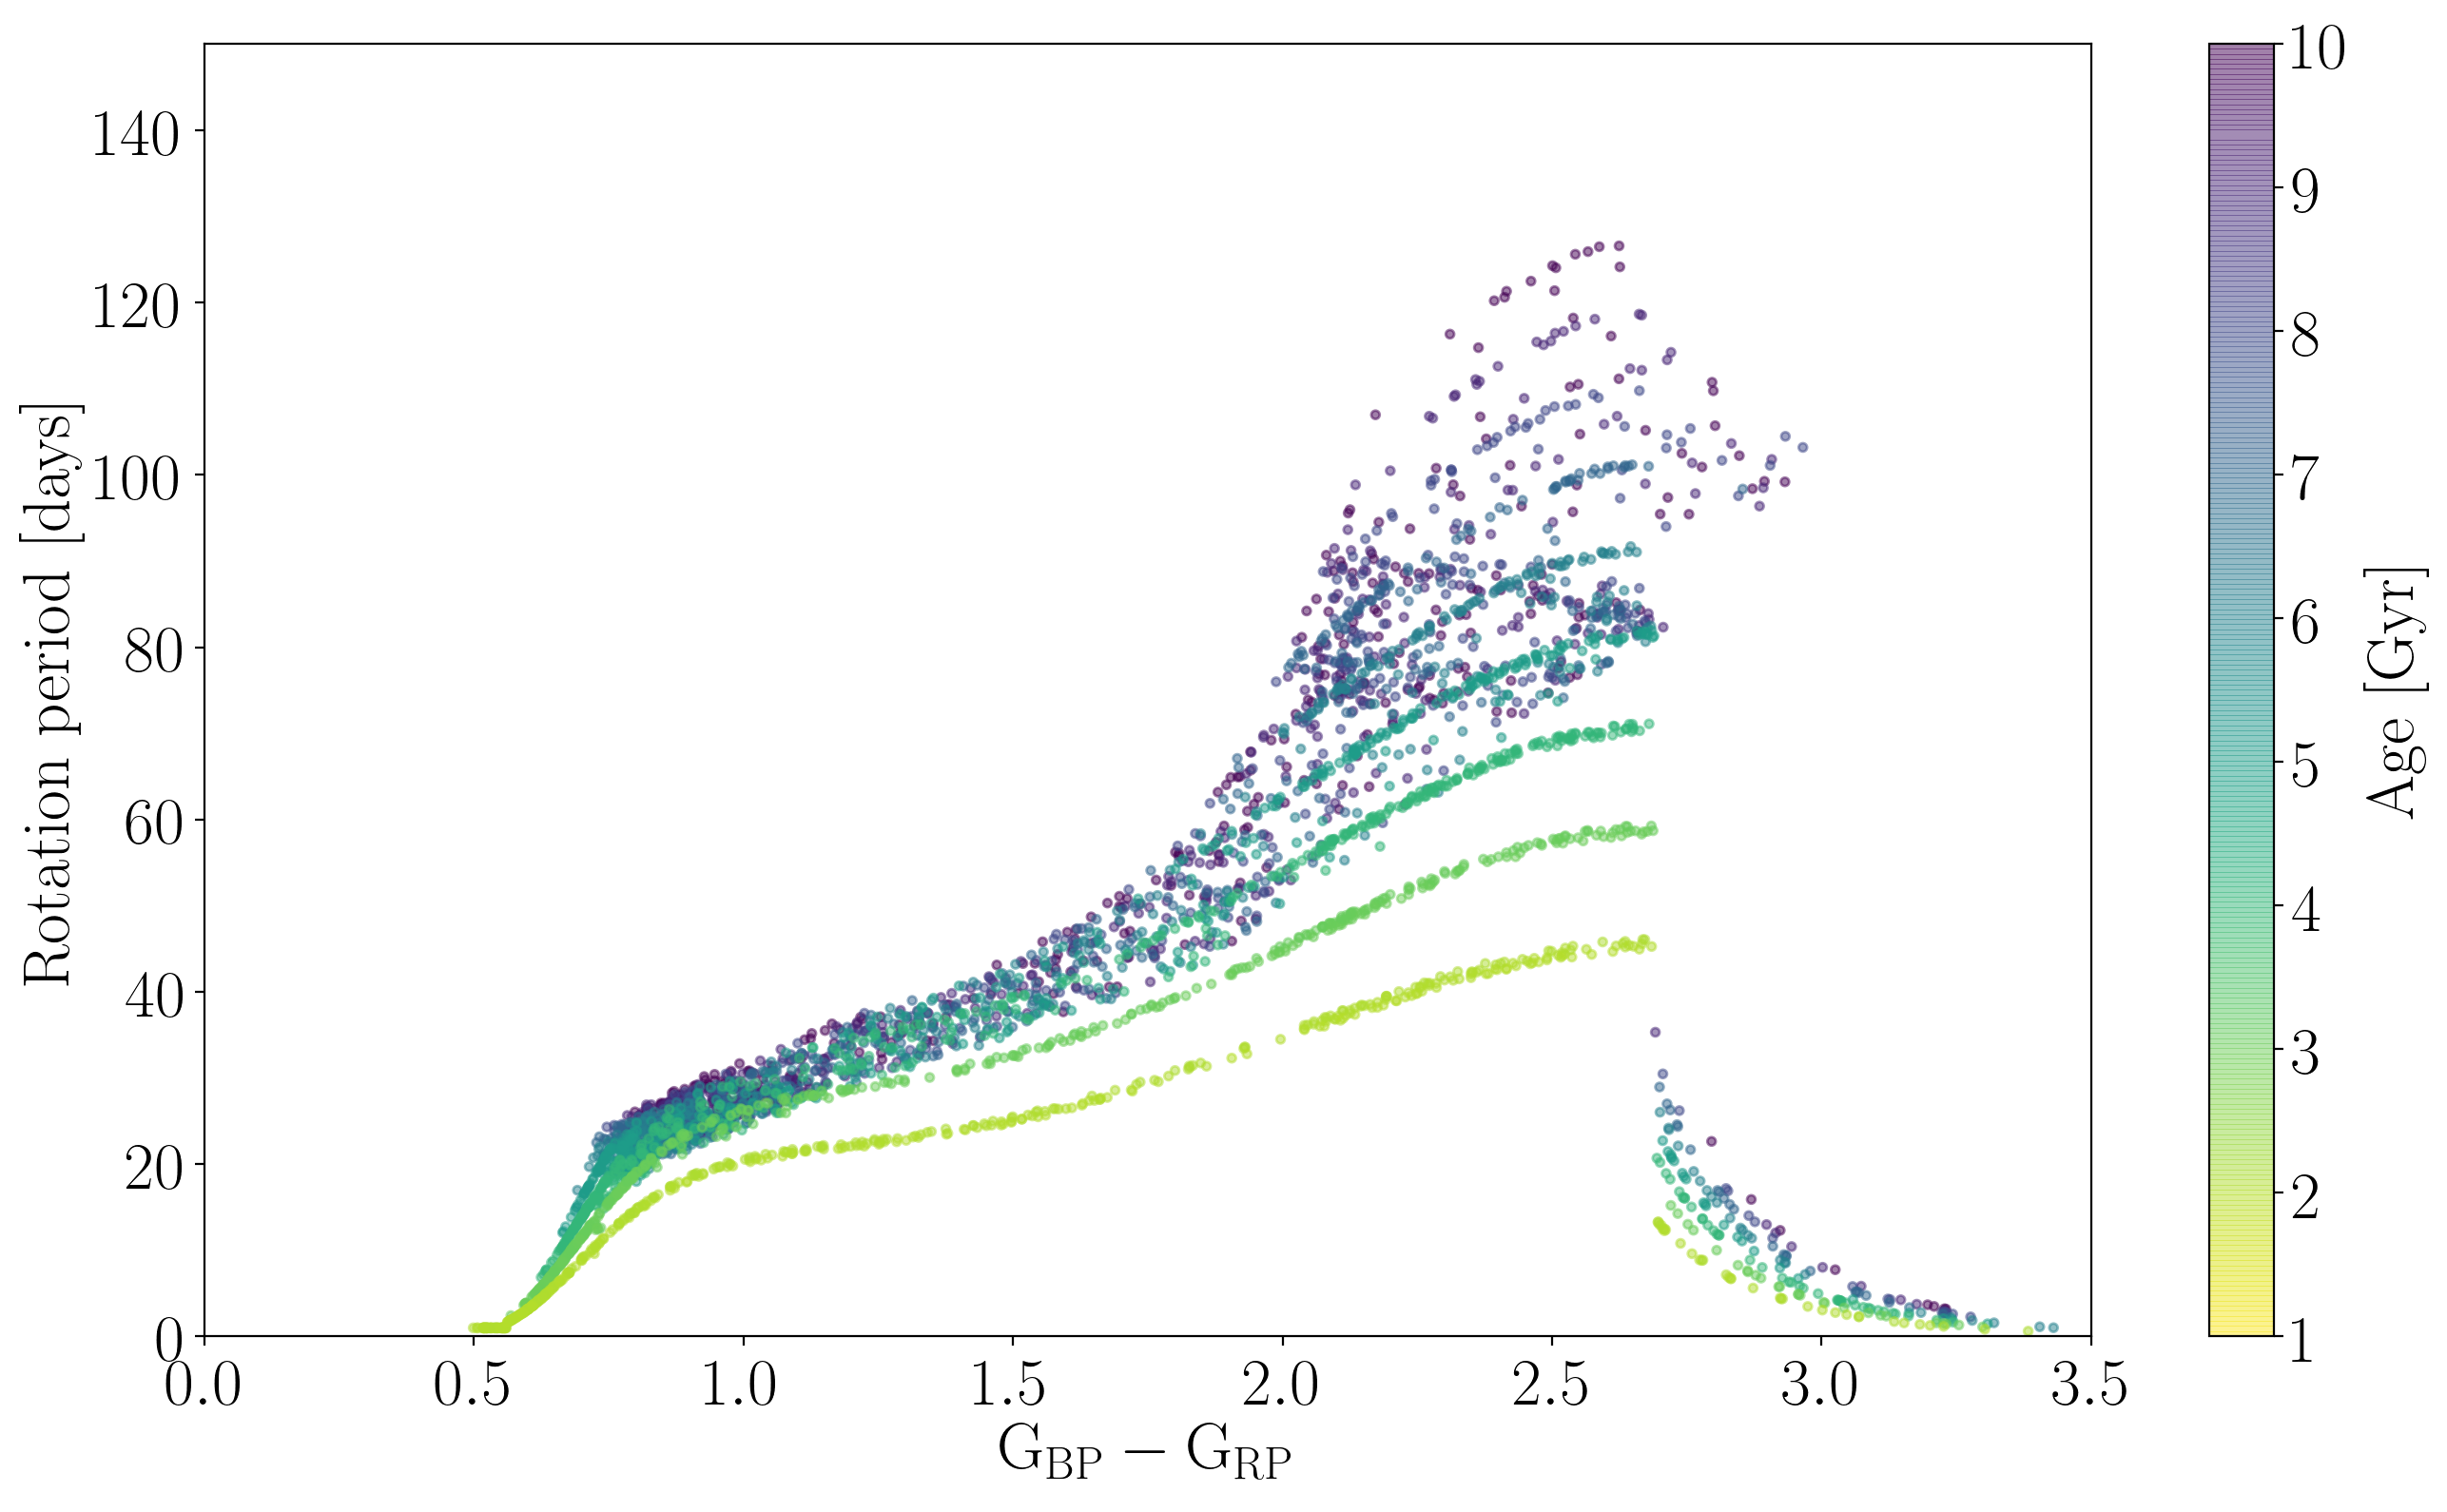

In [36]:
plt.figure(figsize=(16, 9), dpi=200)

age_gyr = (10**finite_df.age)*1e-9
for i in range(10, 1, -1):
    m = (i < age_gyr) * (age_gyr < i+.1) * (finite_df.eep < 400)
    plt.scatter(finite_df.bp[m]-finite_df.rp[m], 10**np.log10(finite_df.prot_clean[m]),
                c=age_gyr[m], vmin=1, vmax=10, s=10, alpha=.5, cmap="viridis_r", rasterized=True)

plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.yscale("log")
plt.ylim(0, 150)
plt.xlim(0, 3.5)

(0, 3.5)

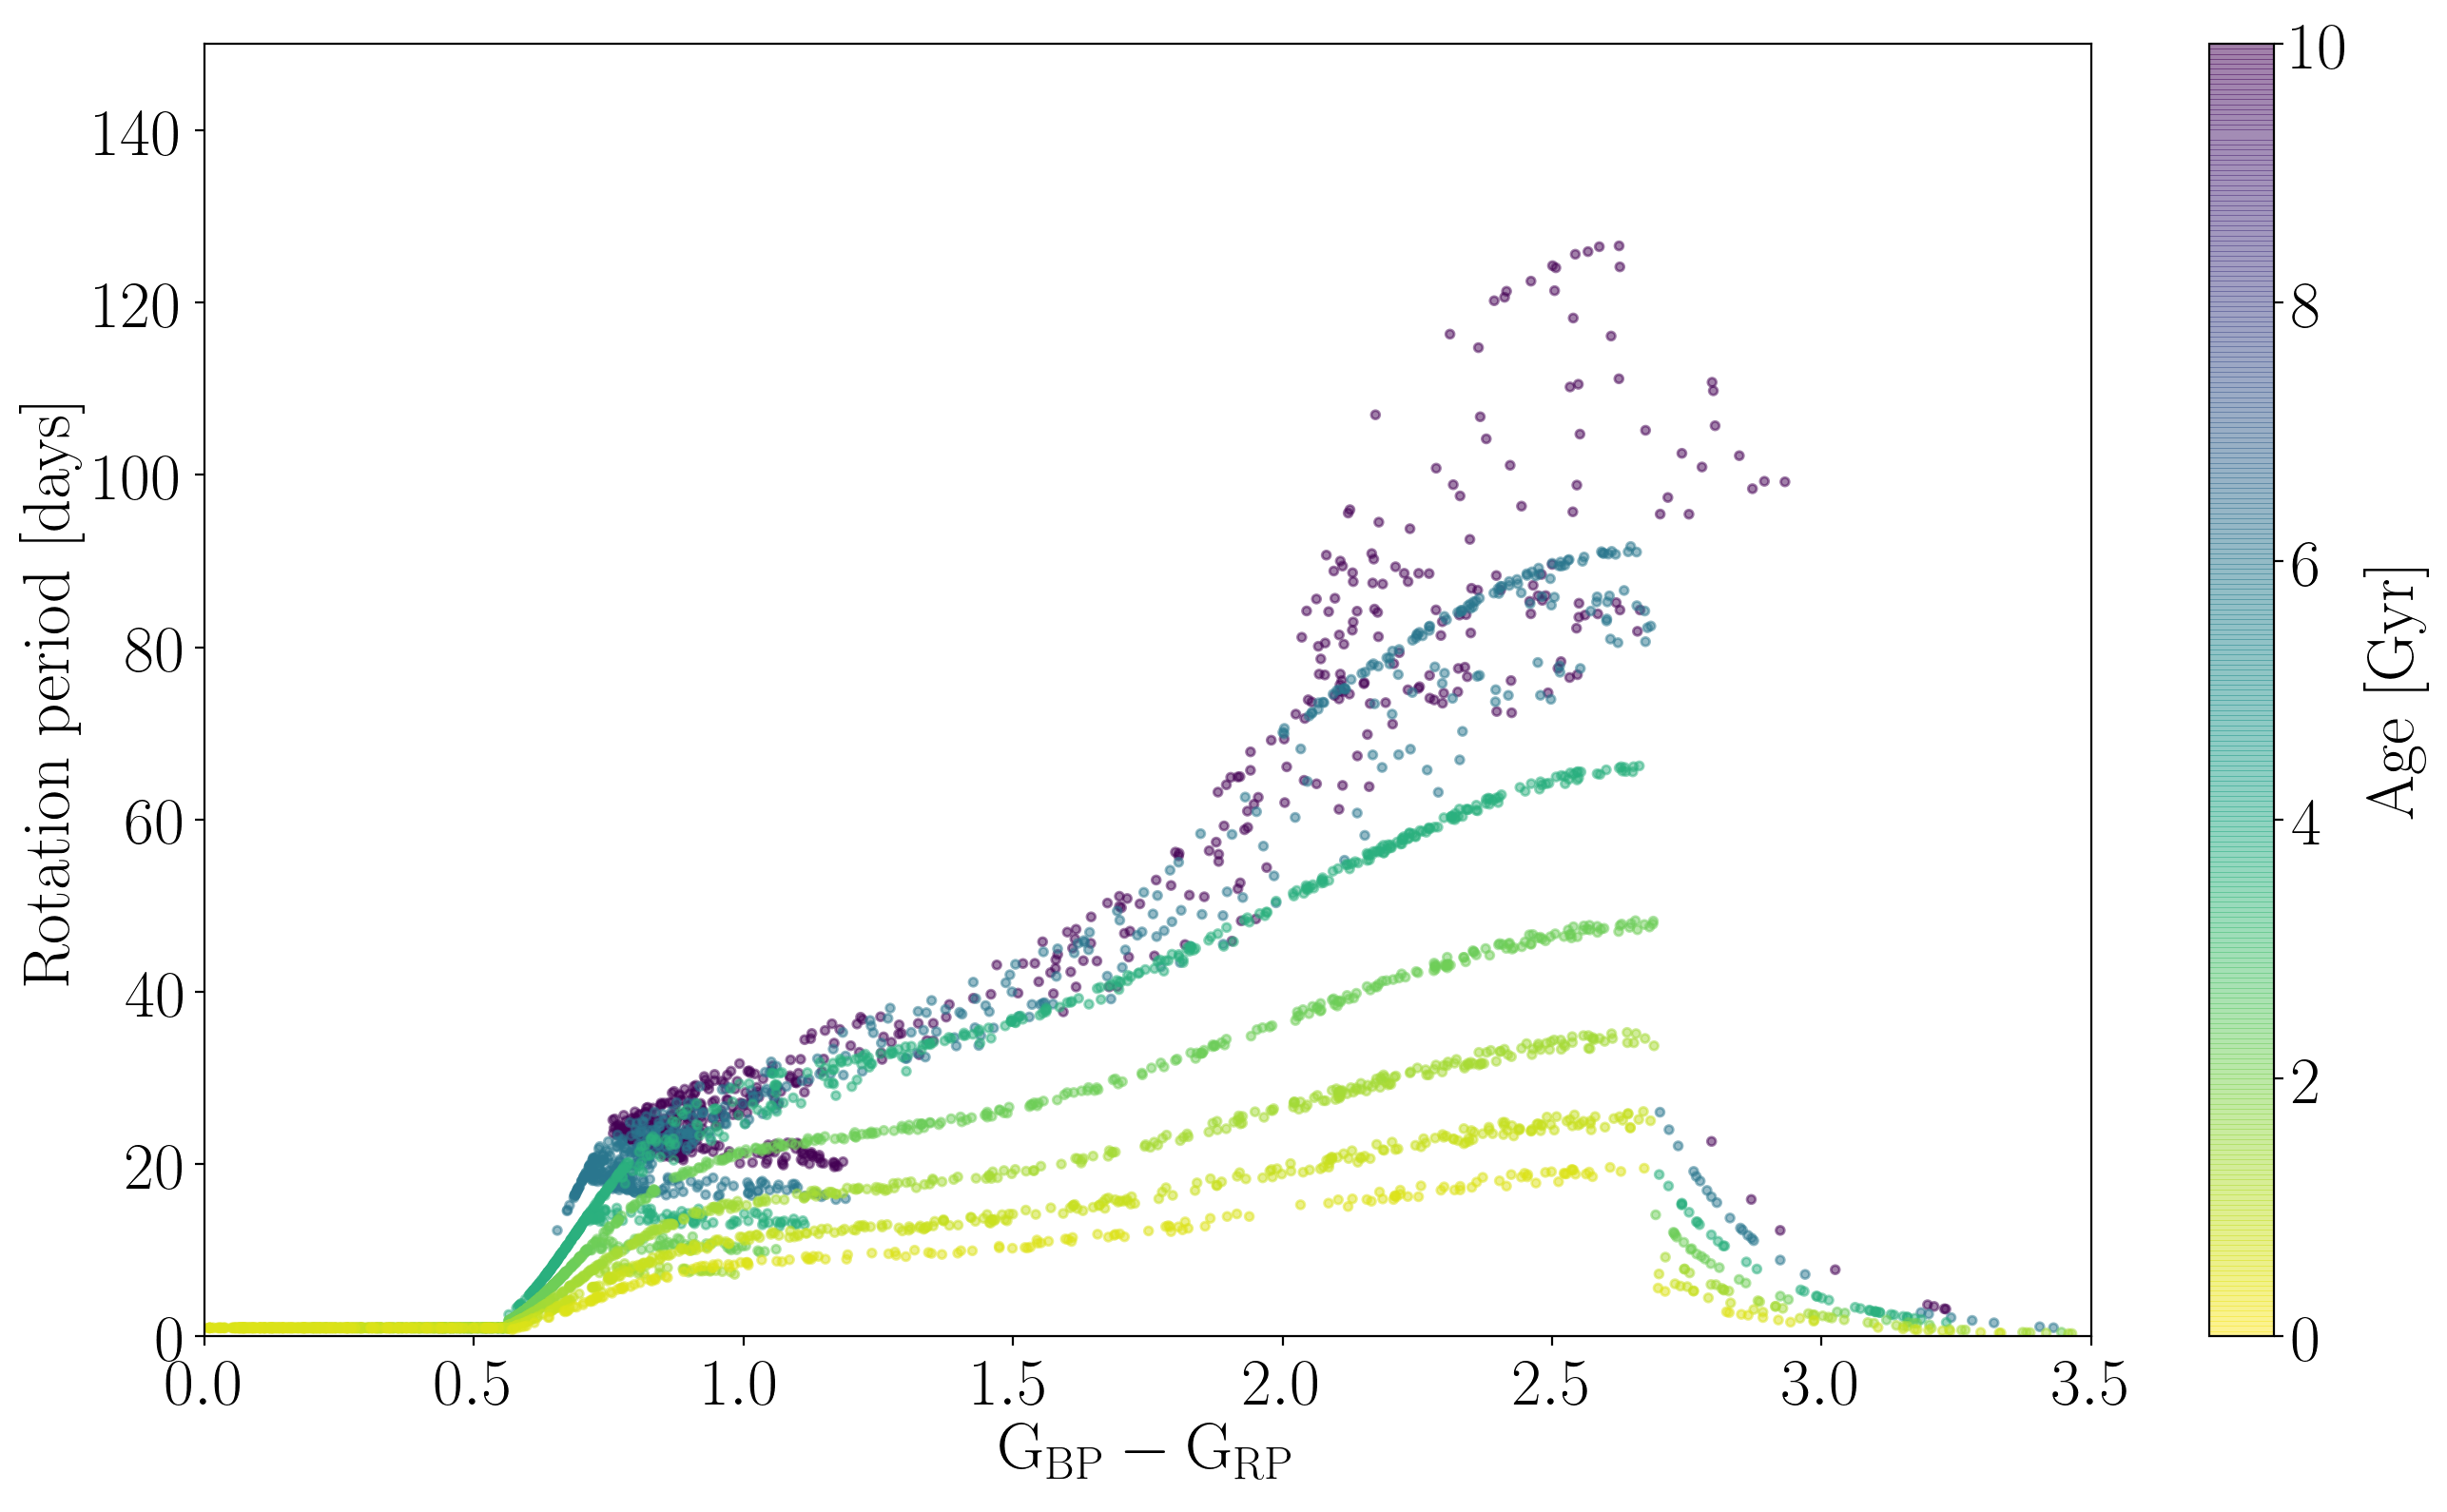

In [37]:
plt.figure(figsize=(16, 9), dpi=200)

age_gyr = (10**finite_df.age)*1e-9
for i in np.linspace(10, 8, 10):
    m = ((10**i)*1e-9 < age_gyr) * (age_gyr < (10**i*1e-9)+.1)
    plt.scatter(finite_df.bp[m]-finite_df.rp[m], 10**np.log10(finite_df.prot_clean[m]),
                c=age_gyr[m], vmin=0, vmax=10, s=10, alpha=.5, cmap="viridis_r", rasterized=True)

plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.yscale("log")
plt.ylim(0, 150)
plt.xlim(0, 3.5)

(0, 60)

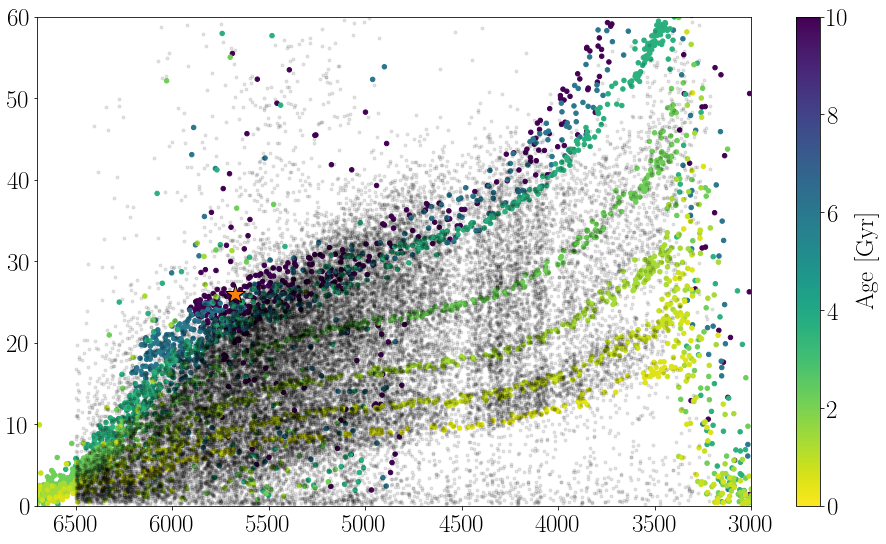

In [38]:
plt.figure(figsize=(16, 9))
mc = pd.read_csv("data/Table_1_Periodic.txt")
# mc
plt.plot(mc.Teff, mc.Prot, "k.", alpha=.1, zorder=1)
plt.xlim(6700, 3000)

for i in np.linspace(10, 8, 10):
    m = ((10**i)*1e-9 < age_gyr) * (age_gyr < (10**i*1e-9)+.1)
    plt.scatter(finite_df.teff[m], 10**np.log10(finite_df.prot[m]), c=age_gyr[m],
                vmin=0, vmax=10, s=20, alpha=1., cmap="viridis_r", rasterized=True)

plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.plot(5677, 26, "*", color="C1", markeredgecolor="k", ms=20)
plt.ylim(0, 60)

In [57]:
vs = pd.read_csv("data/vansaders.csv")

(0, 60)

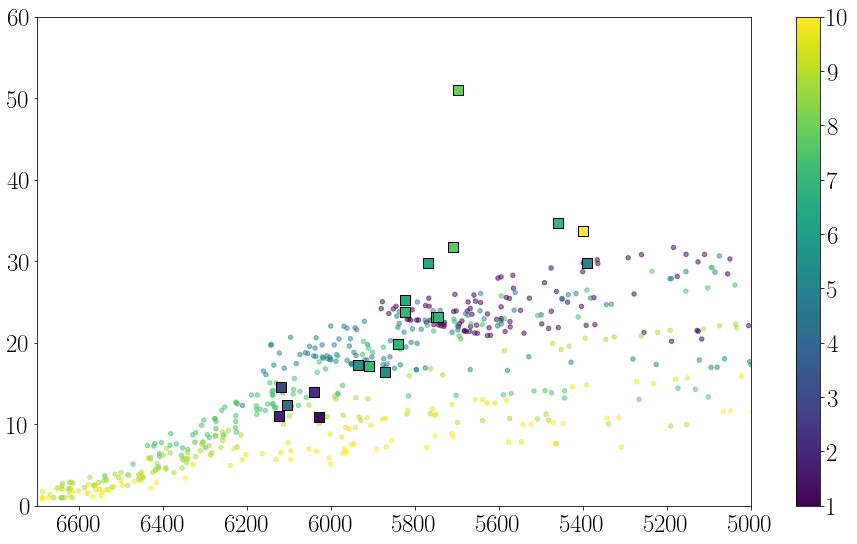

In [85]:
plt.figure(figsize=(16, 9))
m = (8 < age_gyr) * (age_gyr < 8.1)
# plt.scatter(finite_df.teff[m], 10**np.log10(finite_df.prot_clean[m]), c=age_gyr[m], alpha=.5,
#            vmin=1, vmax=10)

for i in np.linspace(10, 8, 10):
    m = ((10**i)*1e-9 < age_gyr) * (age_gyr < (10**i*1e-9)+.03)
    plt.scatter(finite_df.teff[m], 10**np.log10(finite_df.prot_clean[m]), c=age_gyr[m],
                vmin=1, vmax=10, s=20, alpha=.5, cmap="viridis_r", rasterized=True)
                
plt.scatter(vs.teff, vs.period, s=100, edgecolor="k", c=vs.age_basta, vmin=1, vmax=10, marker="s")
plt.colorbar()
plt.xlim(6700, 5000)
plt.ylim(0, 60)

Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

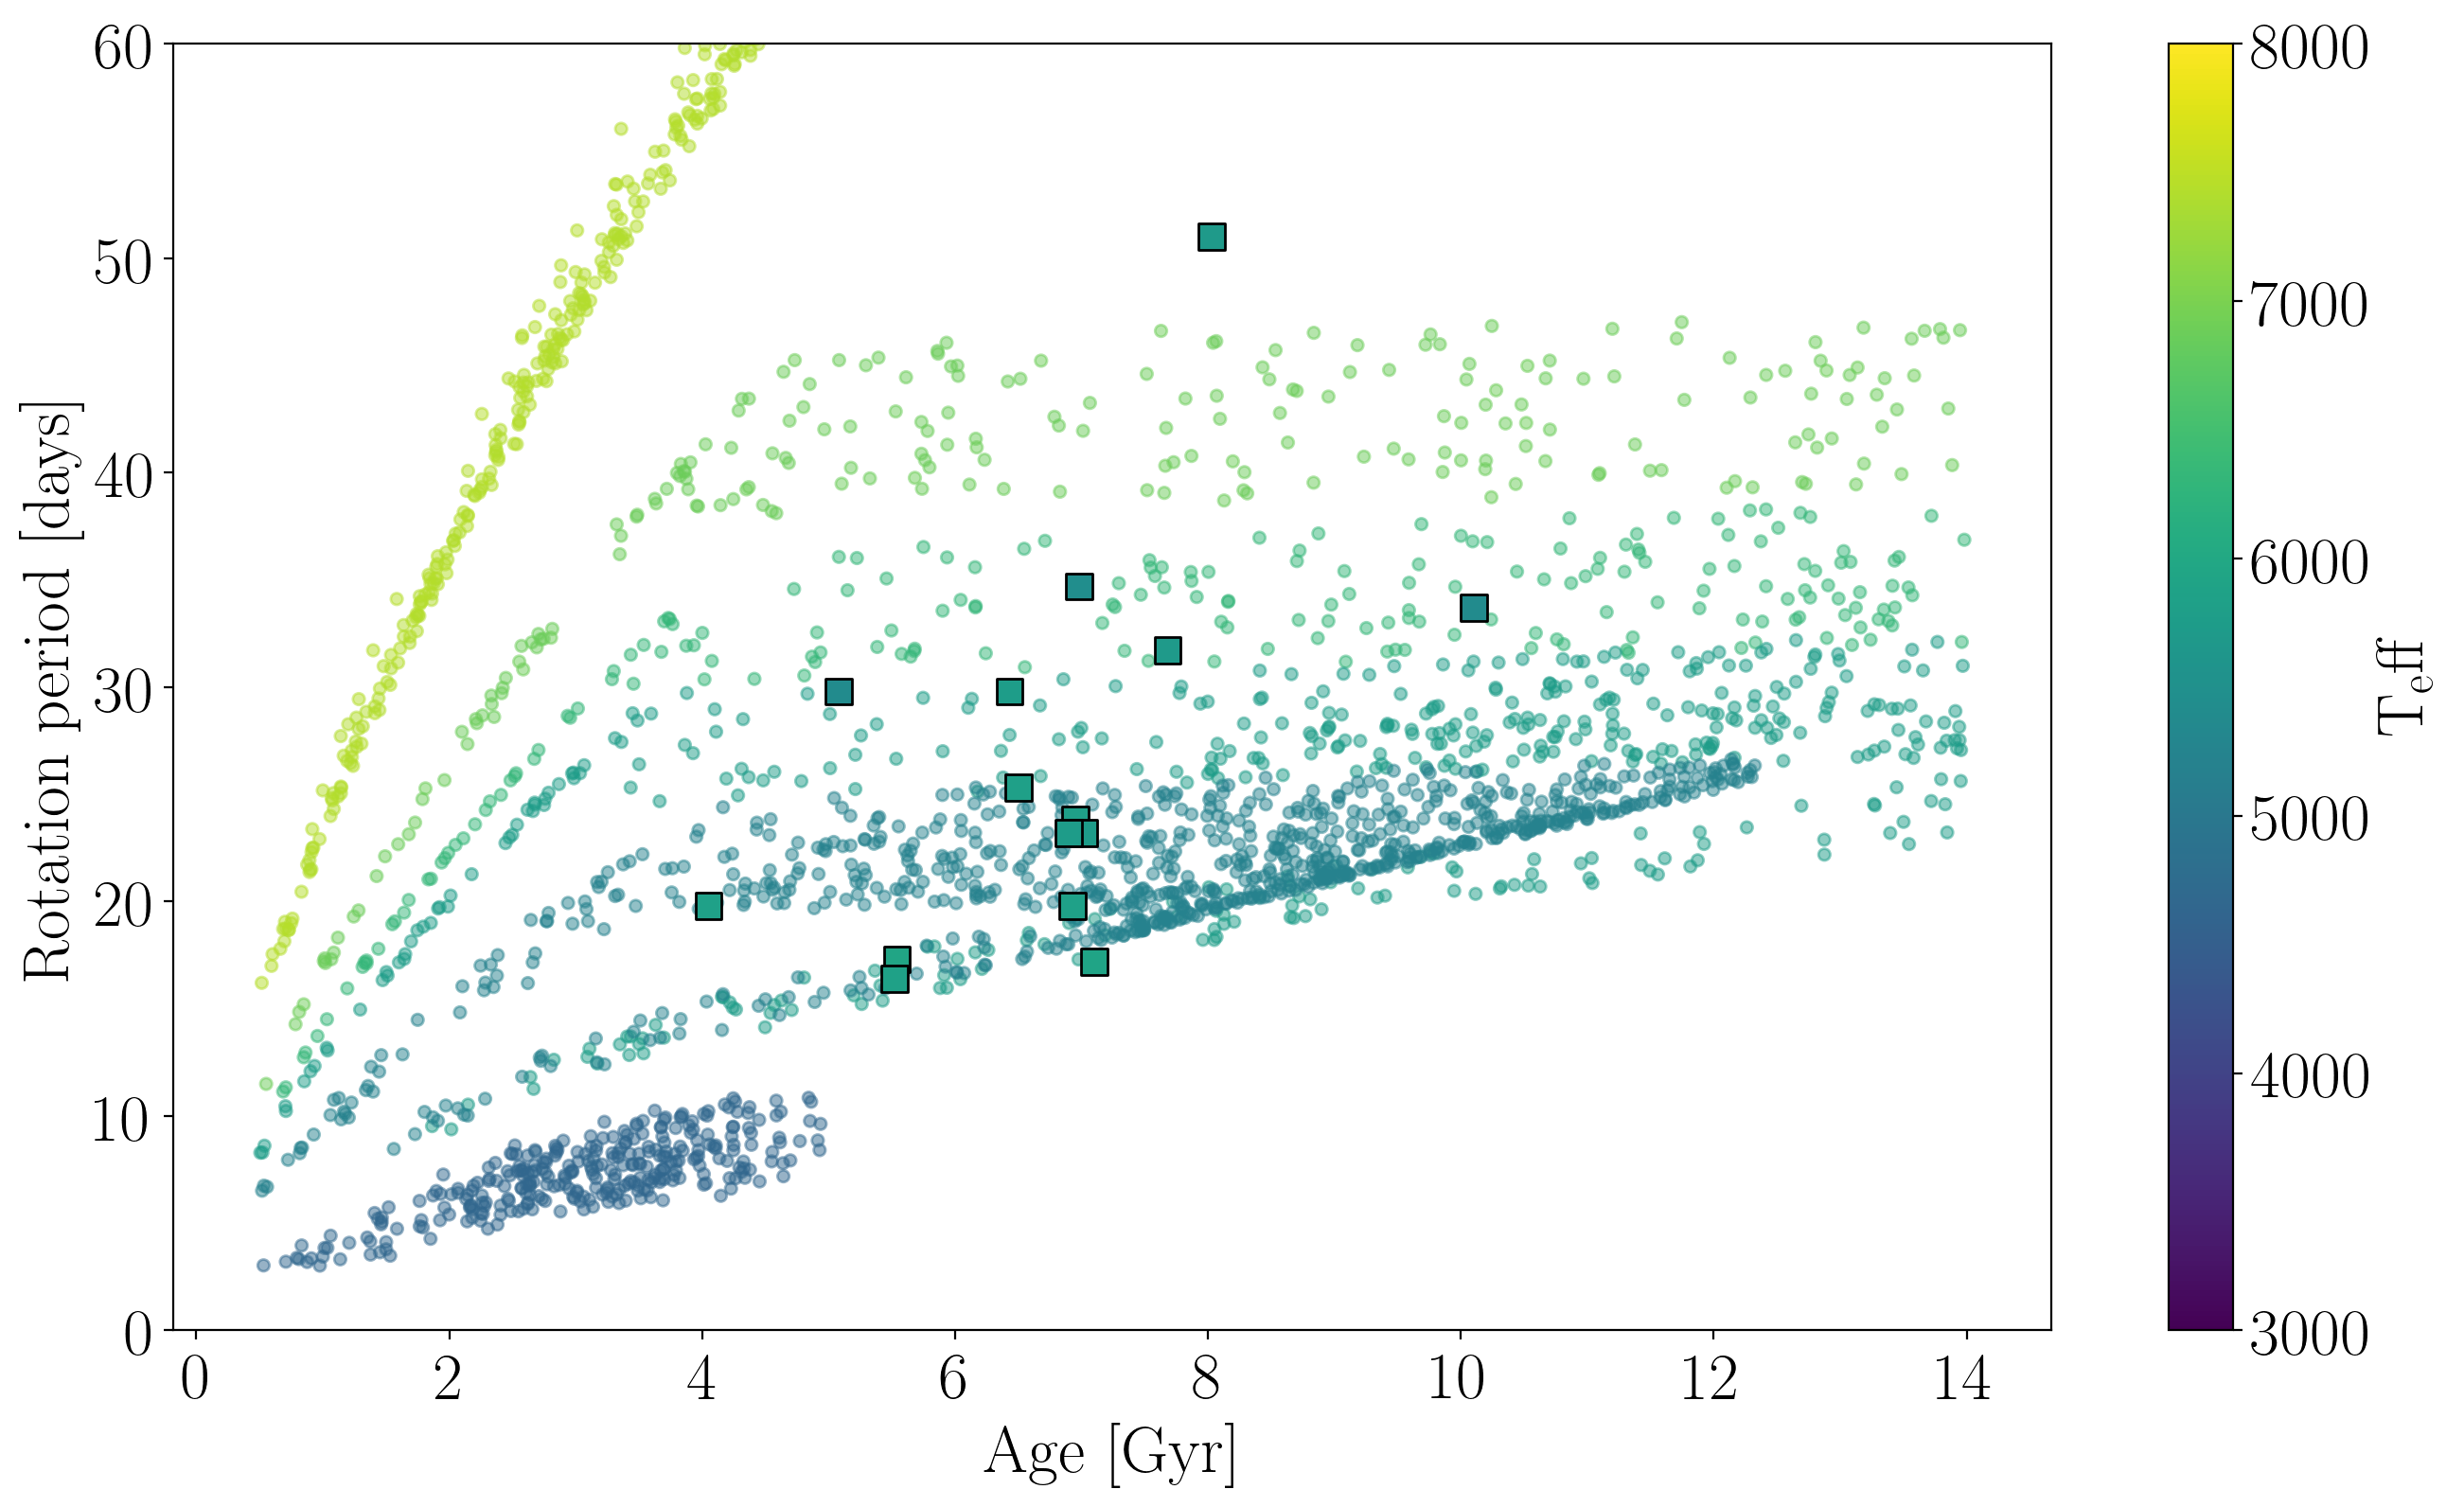

In [104]:
plt.figure(figsize=(16, 9), dpi=200)
m1 = (5000 < df.teff) * (df.teff < 6000) * (df.bp-df.rp > .55) * (2.6 < df.bp-df.rp)

for i in np.linspace(3000, 8000, 10):
    m1 = (i < df.teff) * (df.teff < i + 20) * (.55 < df.bp-df.rp) * (df.bp-df.rp < 2.6)
    plt.scatter(1e-9*(10**finite_df.age[m1]), 10**np.log10(finite_df.prot_clean[m1]), c=df.teff[m1],
                vmin=3000, vmax=8000, s=20, alpha=.5, cmap="viridis_r", rasterized=True)
# plt.scatter(age_gyr[m1], 10**np.log10(finite_df.prot_clean[m1]), c=finite_df.teff[m1], alpha=.5)

m2 = (5000 < vs.teff) * (vs.teff < 6000)
plt.scatter(vs.age_basta[m2], vs.period[m2], s=100, vmin=3000, vmax=8000, edgecolor="k", c=vs.teff[m2], marker="s")
plt.colorbar(label="$\mathrm{T_eff}$")
plt.ylim(0, 60)
plt.xlabel("$\mathrm{Age~[Gyr]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

In [ ]:
plt.figure(figsize=(16, 9))

for i in np.linspace(10, 8, 10):
    m = ((10**i)*1e-9 < age_gyr) * (age_gyr < (10**i*1e-9)+.1)
    plt.scatter(finite_df.teff[m], 10**np.log10(finite_df.prot[m]), c=age_gyr[m],
                vmin=0, vmax=10, s=20, alpha=1., cmap="viridis_r", rasterized=True)

plt.colorbar(label="$\mathrm{Age~[Gyr]}$")
plt.plot(5677, 26, "*", color="C1", markeredgecolor="k", ms=20)
plt.xlim(6700, 3000)
plt.ylim(0, 60)

[-0.02377841544477518, 0.2993416968831915, -1.4414245198557503, 3.403742887270127, -4.339528961538616, 3.0059857021506735]


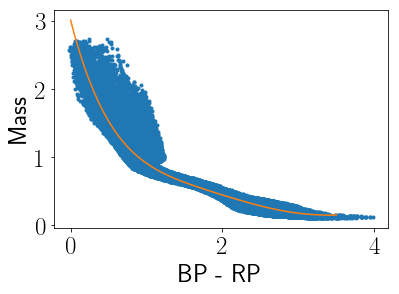

In [9]:
x, y = df.bp - df.rp, df.mass
yerr = np.ones(len(df.mass))*.01
m = np.isfinite(x) * np.isfinite(y)
x, y, yerr = x[m], y[m], yerr[m]

def model(p, x):
    return np.polyval(p, x)

def nll(p, x, y, yerr):
    return -sum(-.5*(model(p, x) - y)**2/yerr**2)

import scipy.optimize as spo
p0 = np.ones(6)
results = spo.minimize(nll, p0, args=(x, y, yerr))

plt.errorbar(x, y, fmt=".", zorder=0)
xs = np.linspace(0, 3.5, 100)
plt.plot(xs, model(results.x, xs), zorder=1)
plt.xlabel("BP - RP")
plt.ylabel("Mass")
print(list(results.x))

def bprp_to_mass(bprp):
    p = [-0.05103786886729474, 0.5403925124845914, 
         -2.215017525879742, 4.493433369049416,
         -4.977087548602282, 3.118005674618441]
    return np.polyval(p, bprp)

Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

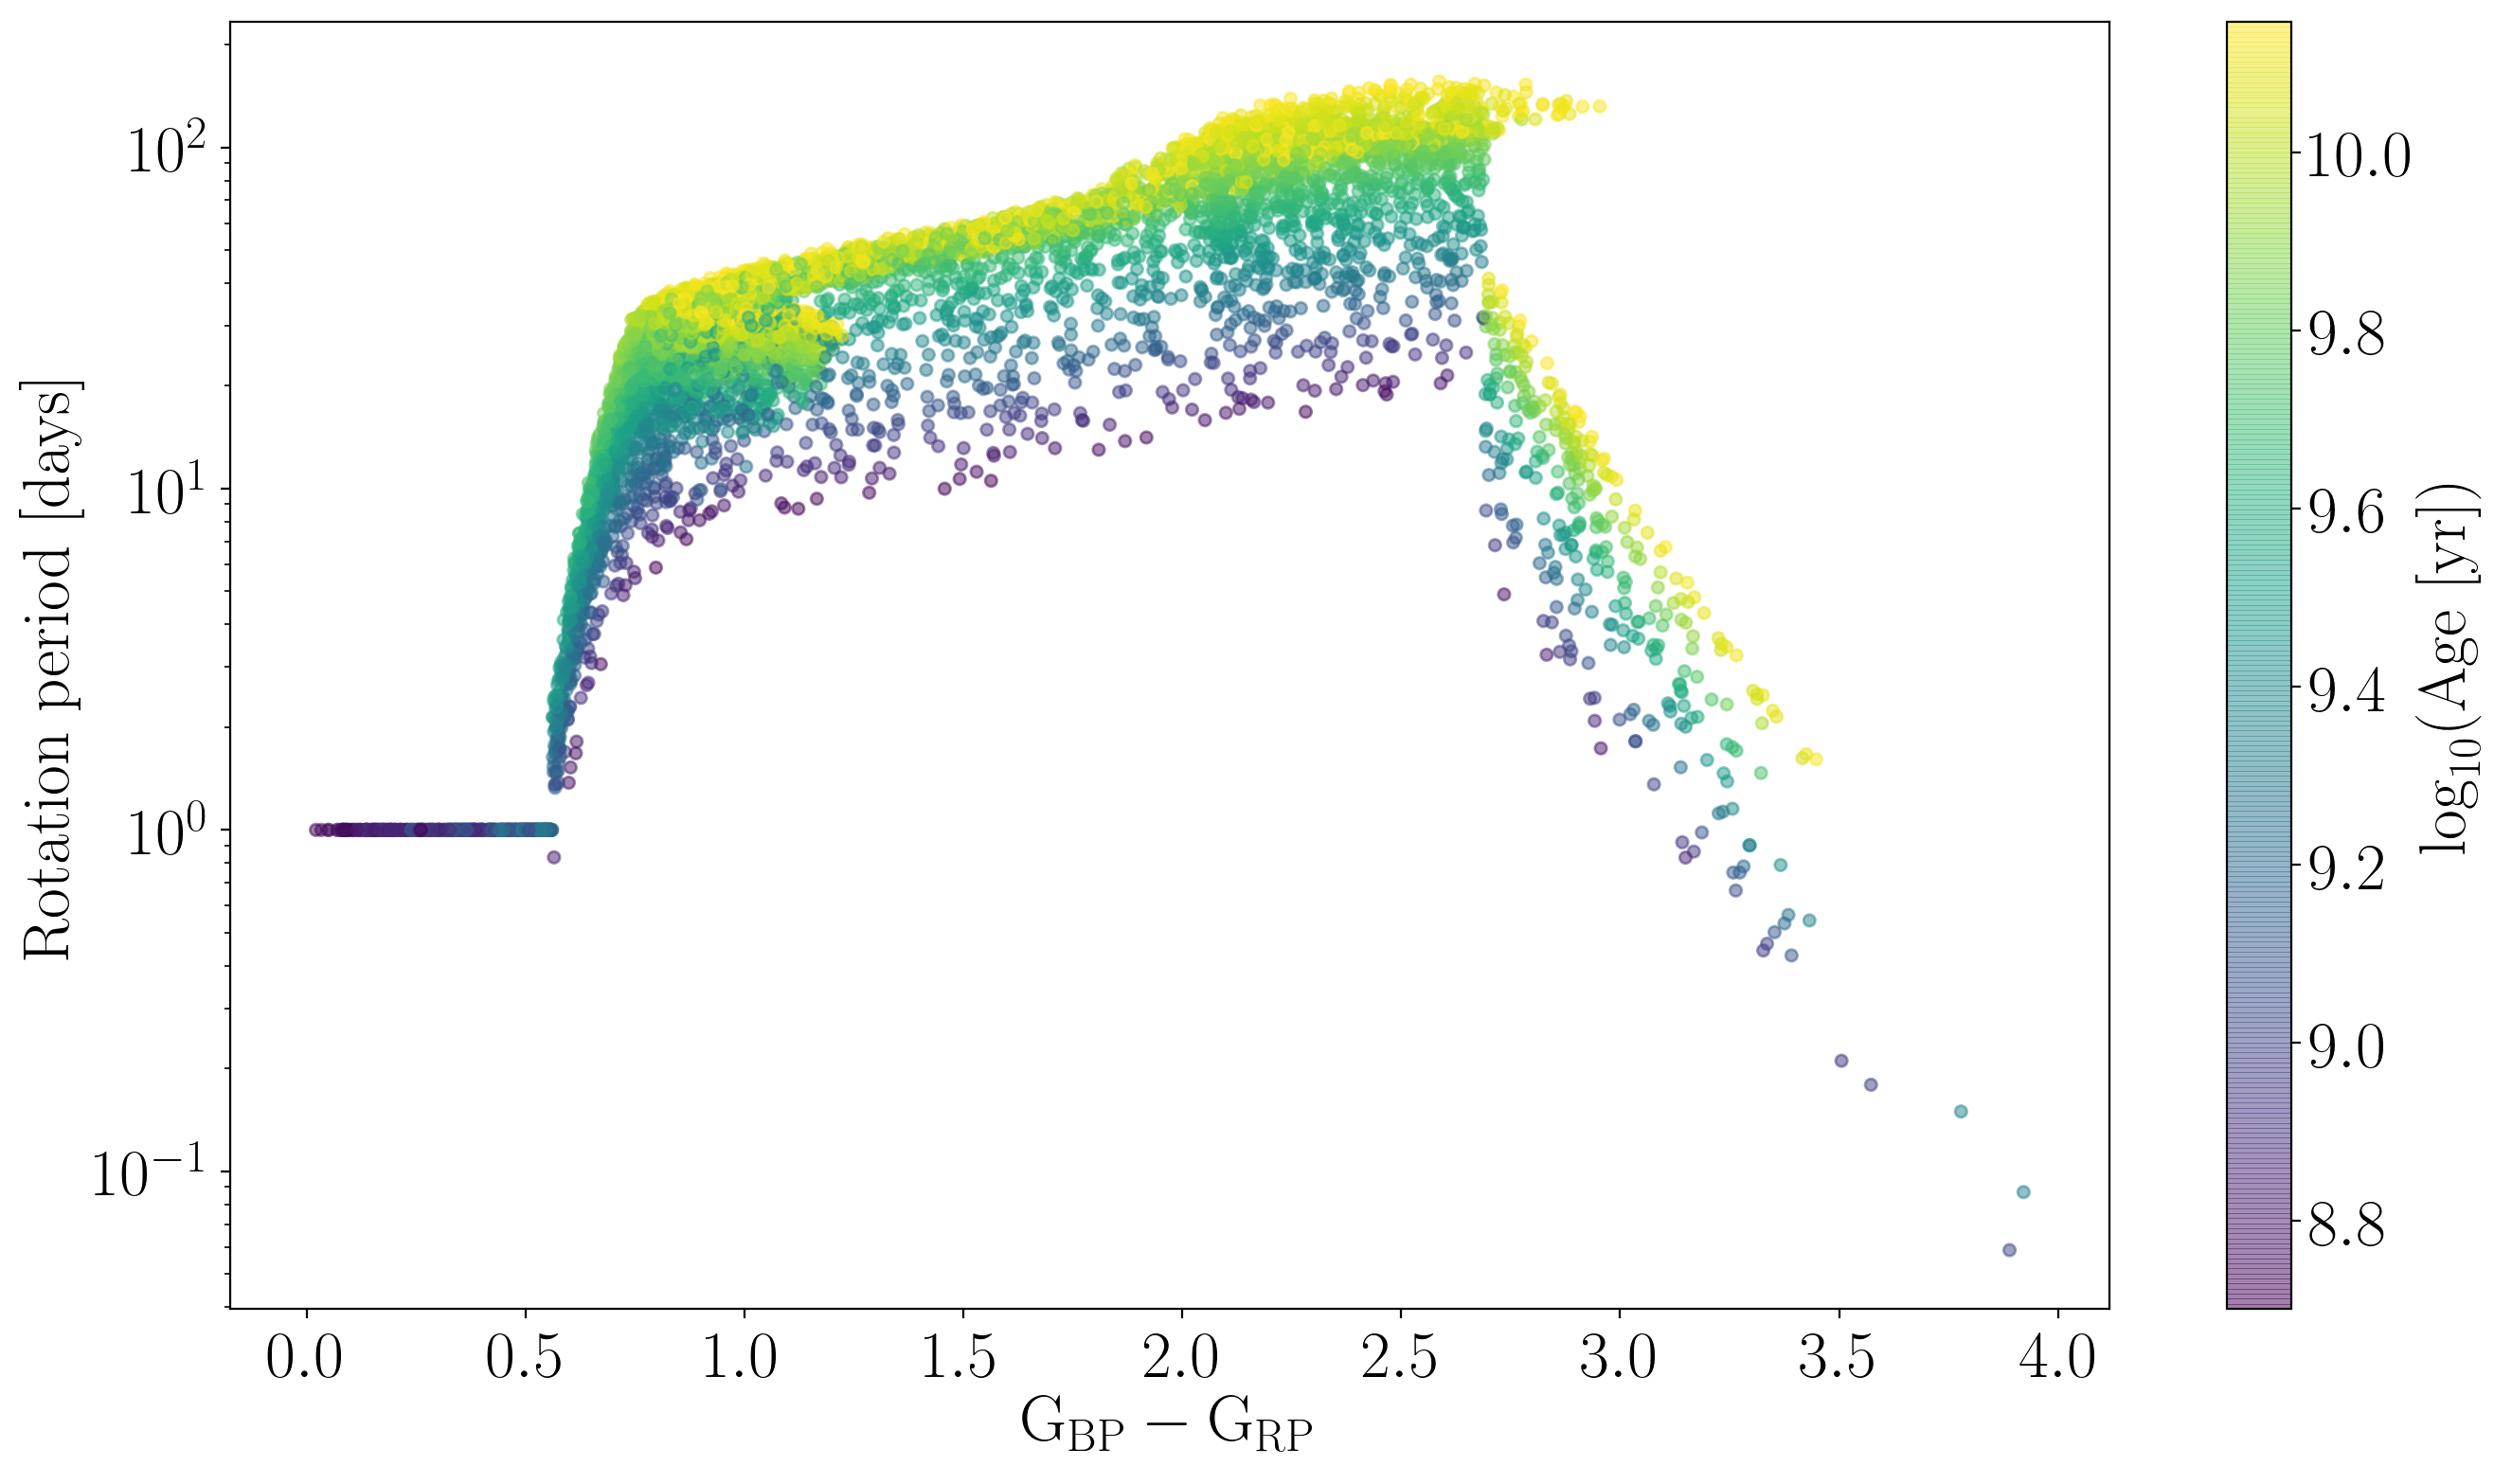

In [182]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
# xs = np.linspace(-.2, .6, 1000)
# masses = bprp_to_mass(10**xs)
# for i in range(len(df)):
# #     plt.plot(10**xs, gyro_model_rossby(np.ones(len(xs))*np.log10(a*1e9), xs, masses),
#     color=".7", ls="--", zorder=0)
#     plt.plot(10**xs, 10**gyro_model_rossby(np.ones(len(xs))*df.age[i], xs, masses),
#              color=".7", alpha=.01, zorder=0)
plt.yscale("log")

plt.scatter(finite_df.bp-finite_df.rp, 10**np.log10(finite_df.prot),
            c=finite_df.age, s=20, alpha=.5, zorder=1)
plt.colorbar(label="$\log_{10}(\mathrm{Age~[yr]})$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")


Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

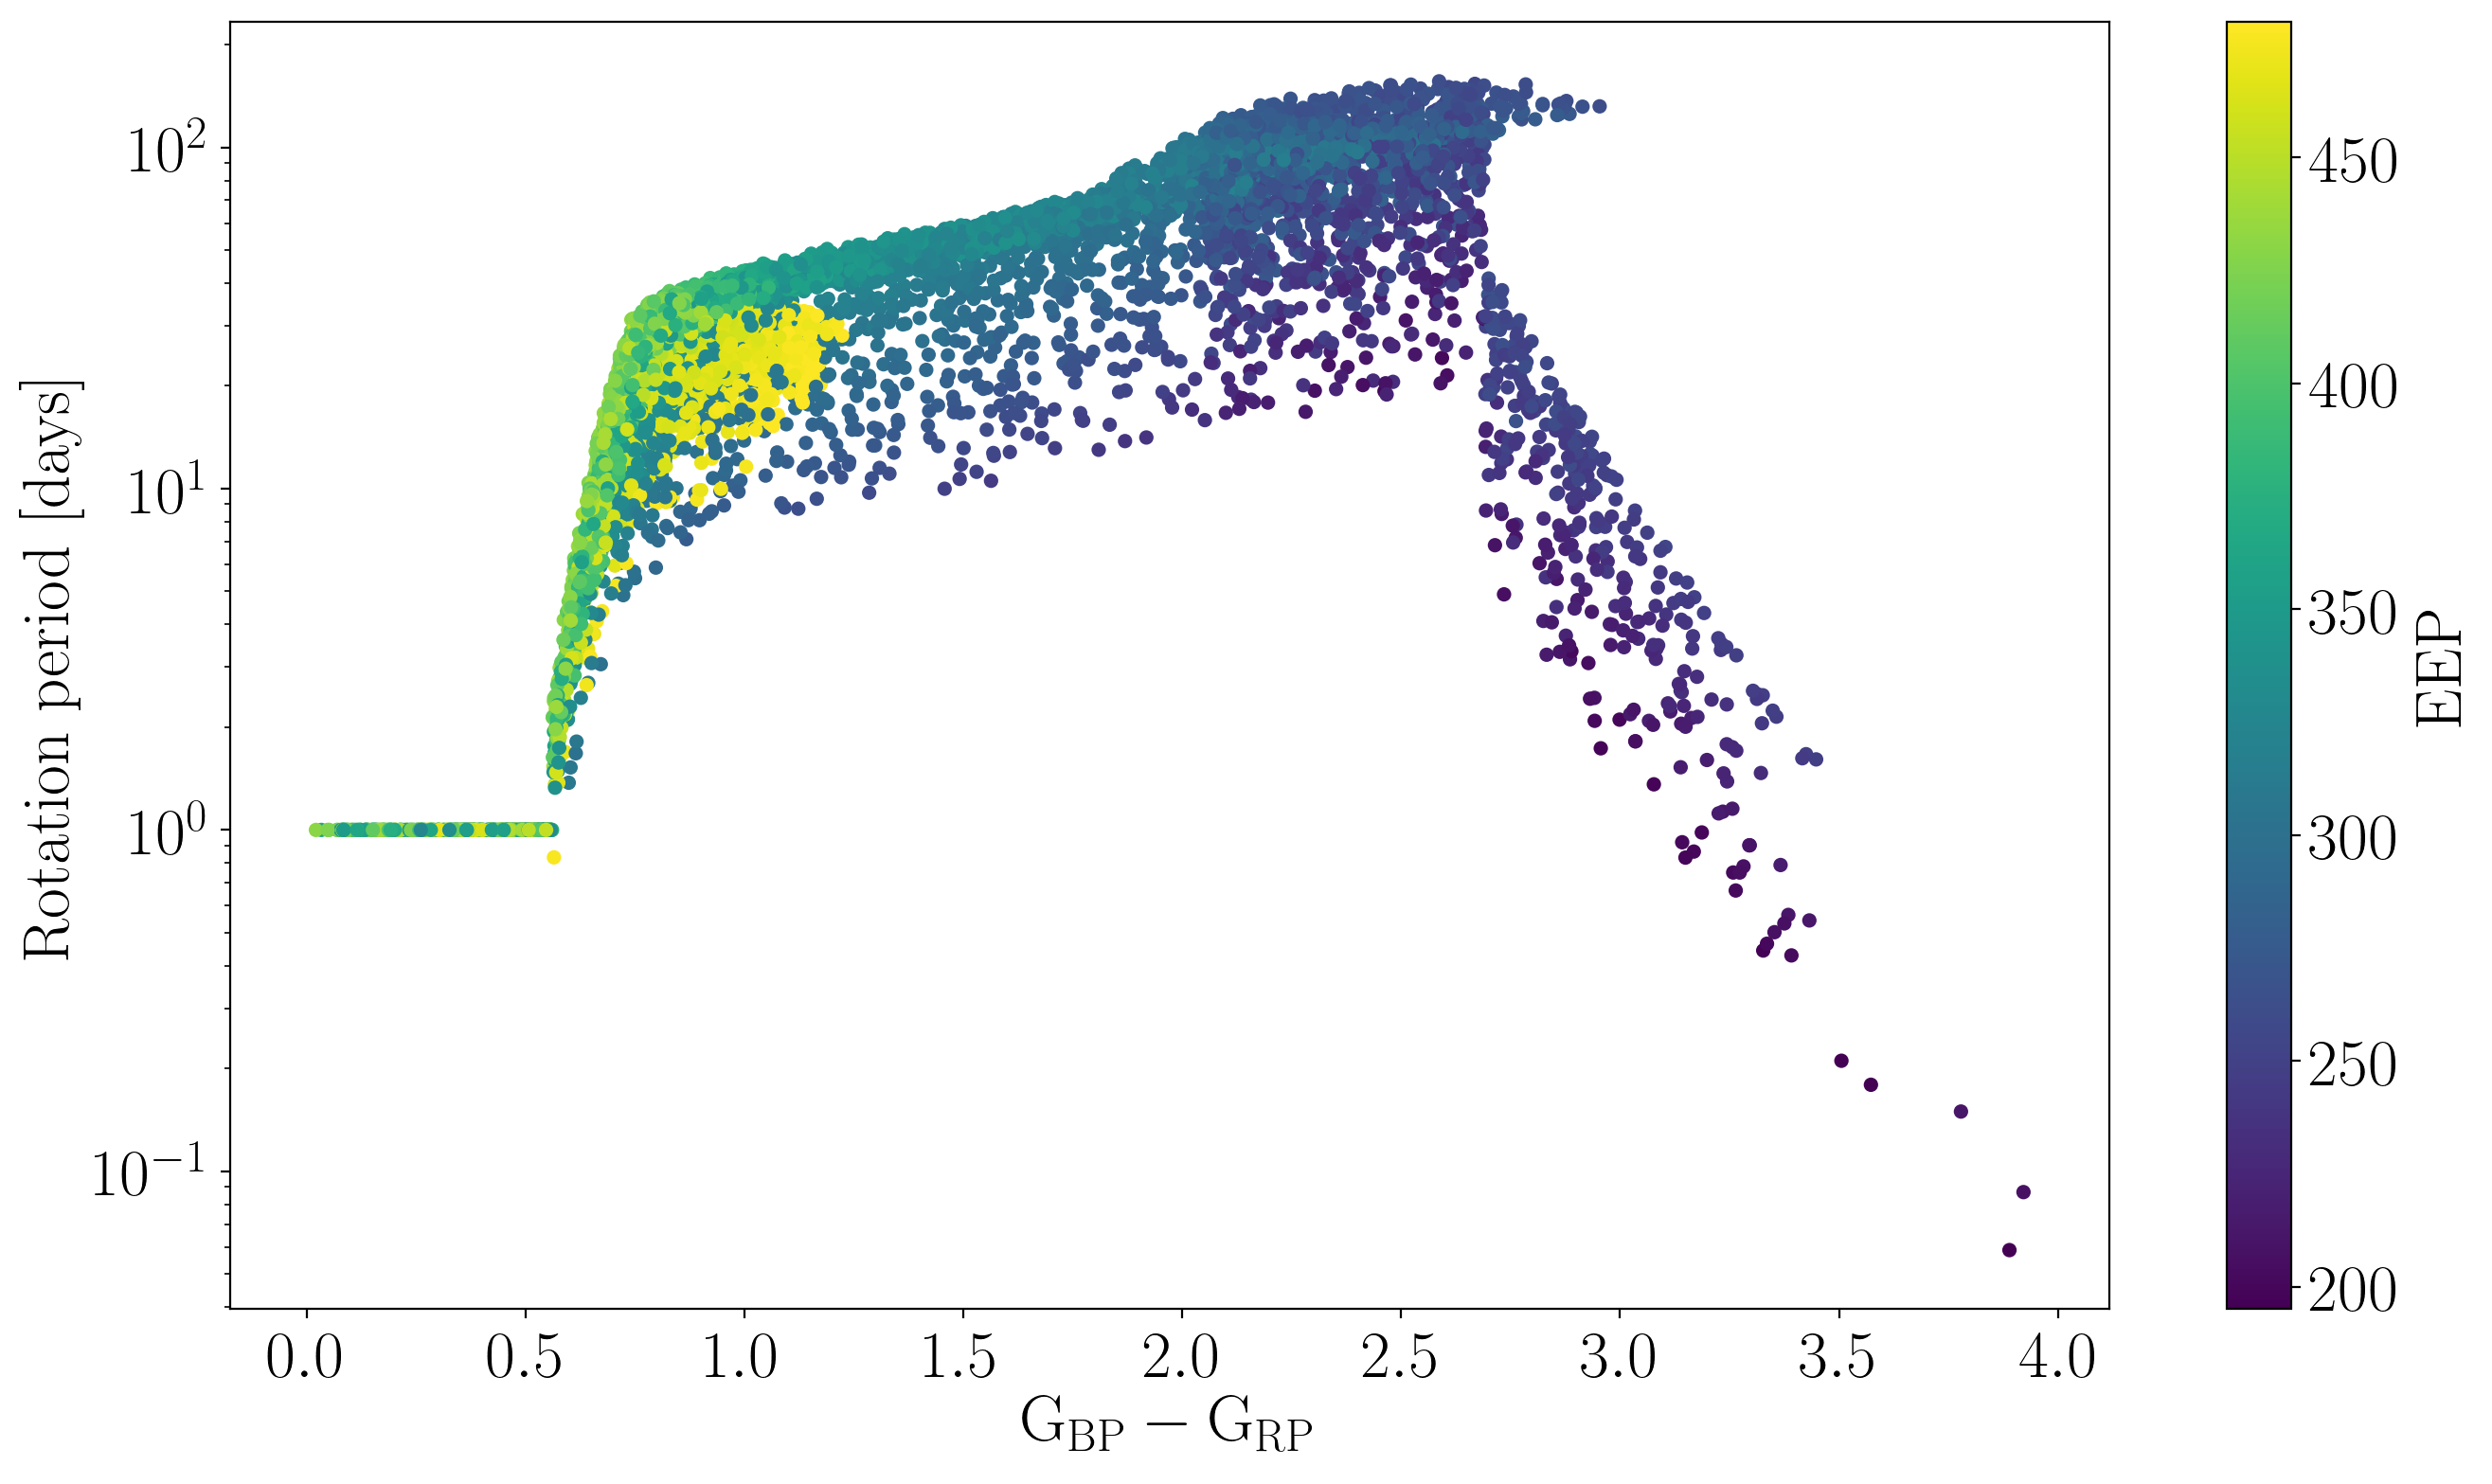

In [183]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
# for i in range(len(df)):
#     plt.plot(10**xs, 10**gyro_model_rossby(np.ones(len(xs))*df.age[i], xs, masses),
#              color=".7", alpha=.01, zorder=0)
plt.yscale("log")

plt.scatter(finite_df.bp-finite_df.rp, 10**np.log10(finite_df.prot), c=finite_df.eep, s=20, zorder=1)
plt.colorbar(label="$\mathrm{EEP}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

Text(0, 0.5, '$\\mathrm{Rotation~period~[days]}$')

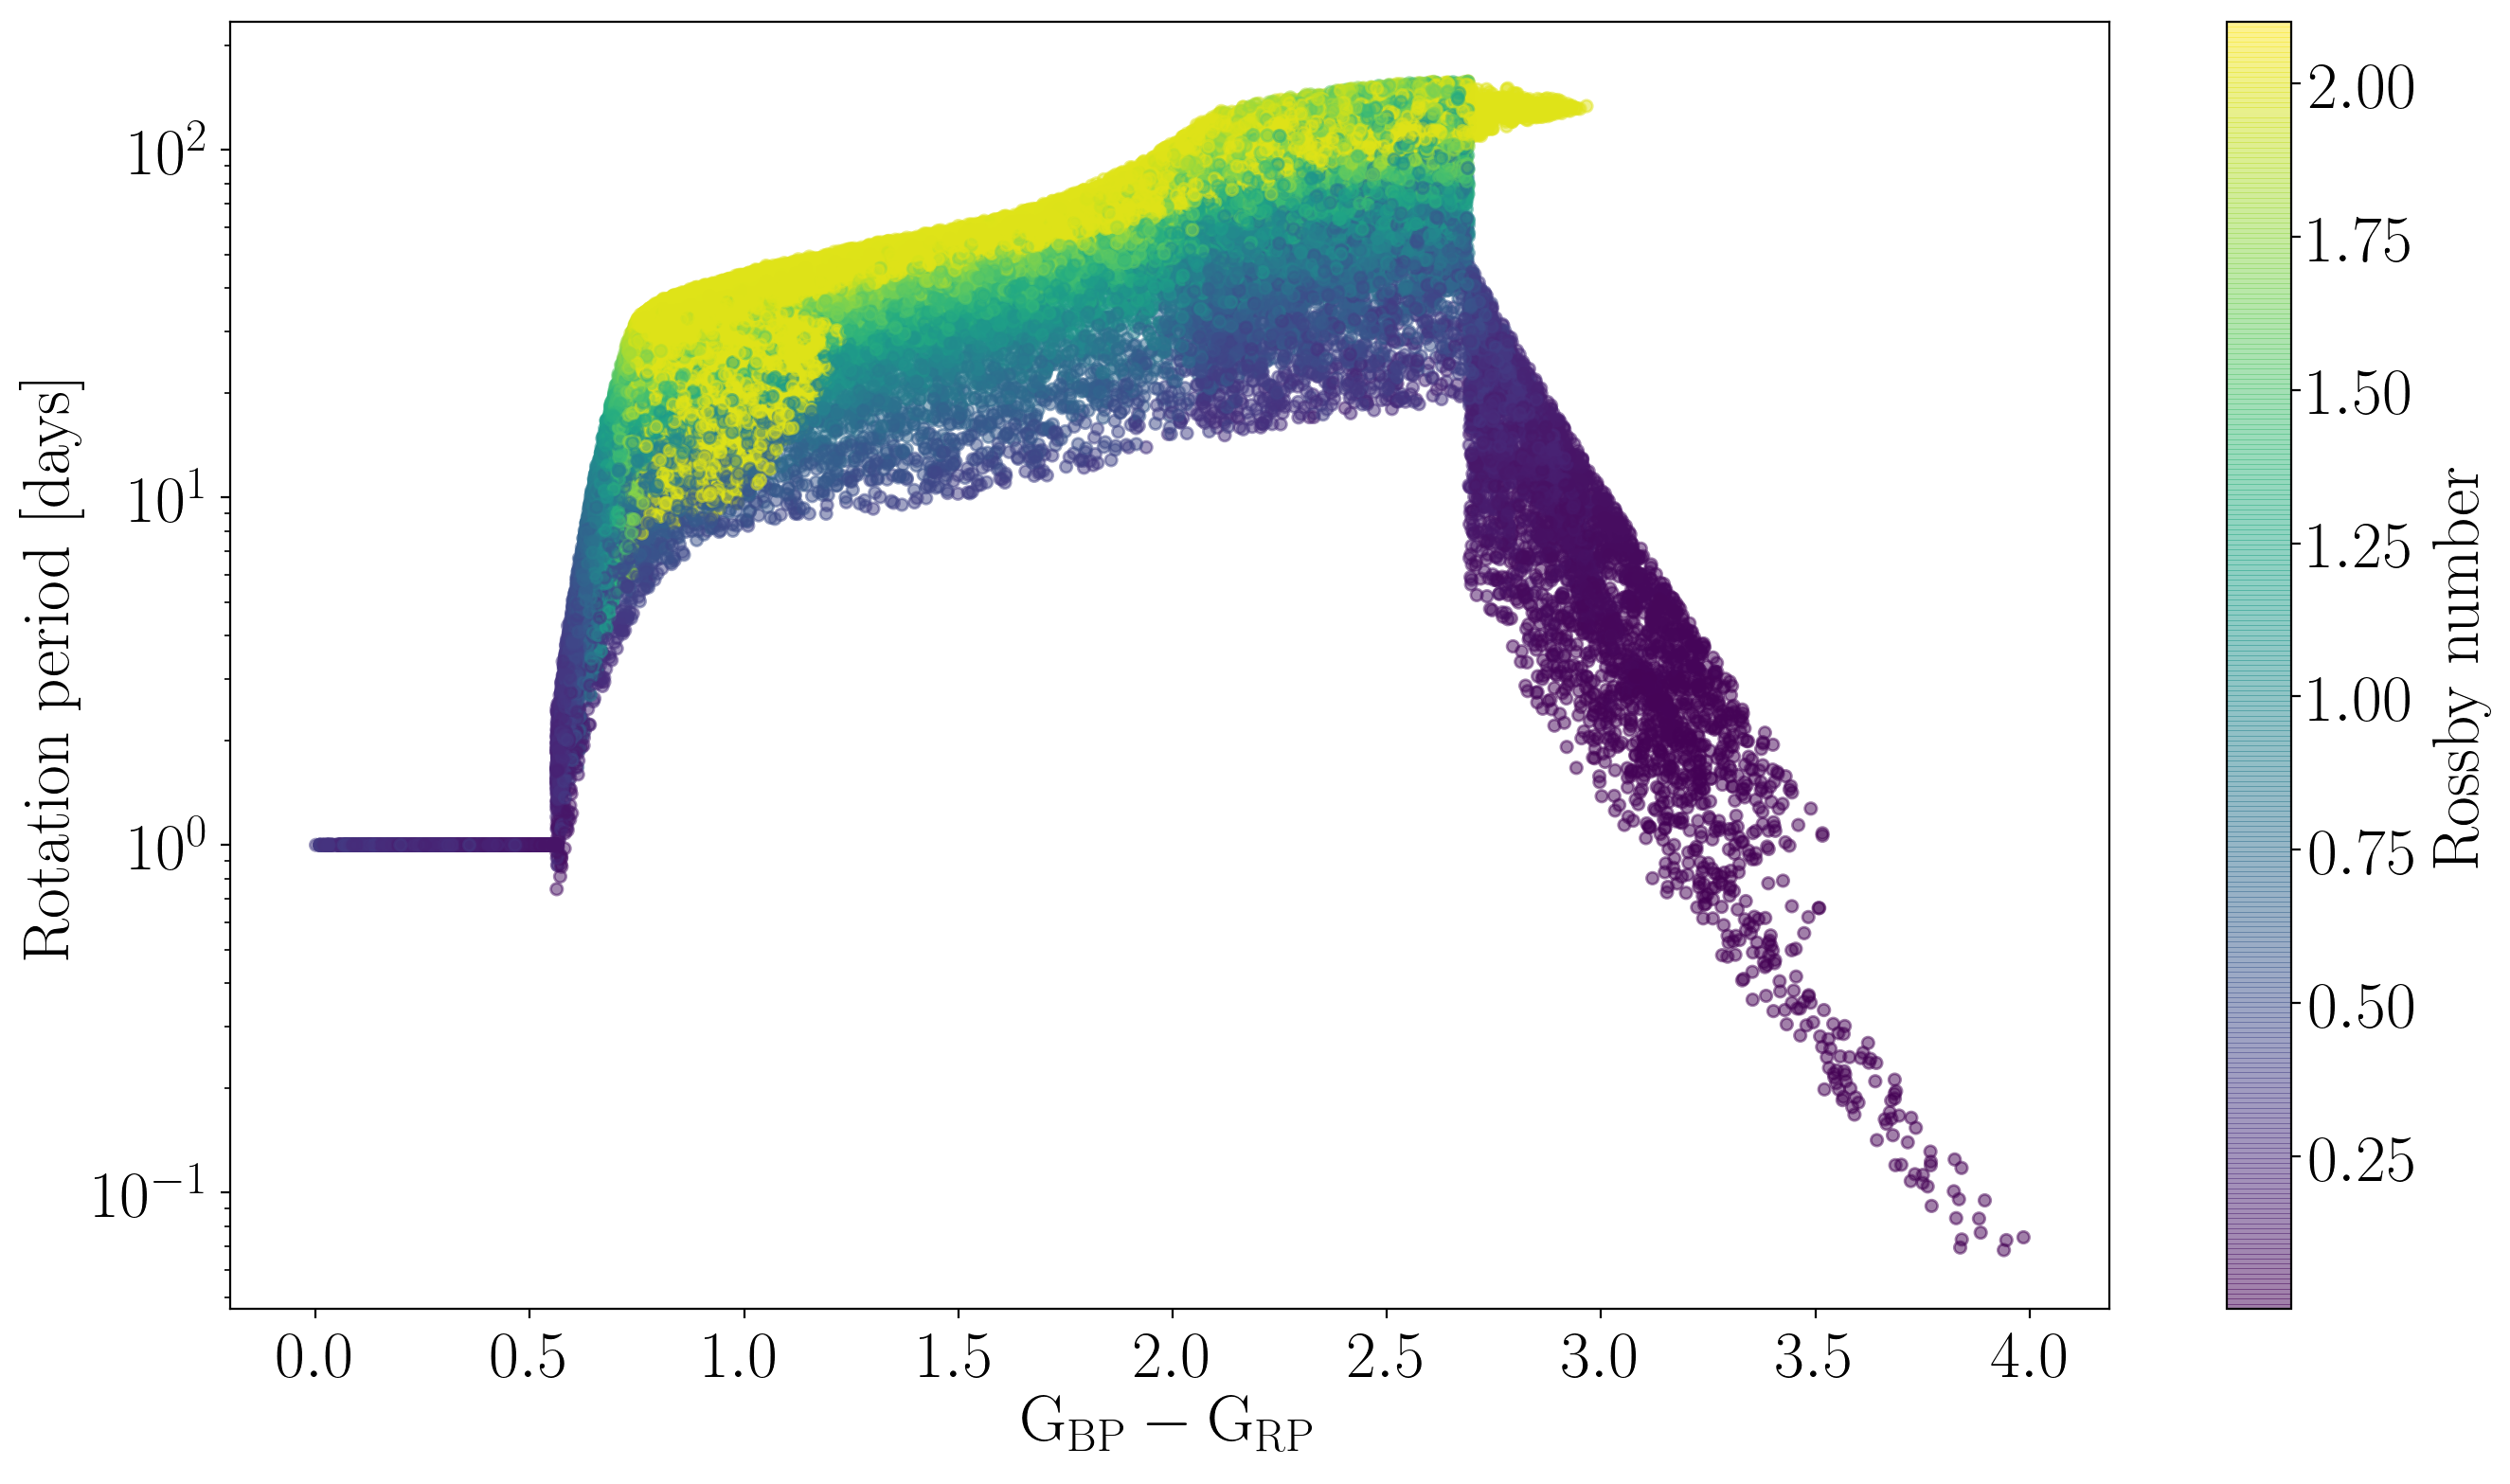

In [212]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
# for i in range(len(df)):
#     plt.plot(10**xs, 10**gyro_model_rossby(np.ones(len(xs))*df.age[i], xs, masses),
#              color=".7", alpha=.05, zorder=0)
plt.yscale("log")

plt.scatter(finite_df.bp-finite_df.rp, 10**np.log10(finite_df.prot), 
            c=finite_df.Ro, s=20, vmax=2.1, zorder=1, alpha=.5)
plt.colorbar(label="$\mathrm{Rossby~number}$")
plt.xlabel("$\mathrm{G_{BP}-G_{RP}}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
# plt.ylim(5, 150)
# plt.xlim(.5, 3)

In [13]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.45, 1.7, 100)
for a in range(1, 14, 2):
    plt.loglog(xs, gyro_model_rossby(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

hot_mask = finite_df.BV < .45
cool_mask = 1.25 < finite_df.BV
evolved_mask = (.45 < finite_df.BV) * (454 < finite_df.eep)

plt.loglog(finite_df.BV, finite_df.prot, ".", ms=15 , zorder=0, label="MS dwarfs")
plt.loglog(finite_df.BV[hot_mask], finite_df.prot[hot_mask], ".", ms=15 , zorder=1, label="Hot stars")
plt.loglog(finite_df.BV[cool_mask], finite_df.prot[cool_mask], ".", ms=15 , zorder=1, label="Cool stars")
plt.loglog(finite_df.BV[evolved_mask], finite_df.prot[evolved_mask], ".", ms=15, zorder=1, label="Evolved")
plt.legend()
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

NameError: name 'gyro_rot' is not defined

<Figure size 3200x1800 with 0 Axes>

In [ ]:
bv_plot = np.linspace(.45, 2., 1000)
mass_plot = np.linspace(1.25, .3, 1000)
period_plot = np.empty((14, 1000))

for j in range(14):
    for i in range(1000):
        period_plot[j, i] = gyro_model_rossby(np.log10(j*1e9), bv_plot[i], mass_plot[i])
        
plt.figure(figsize=(16, 9), dpi=200)
plt.plot(bv_plot, period_plot[2, :], label="$\mathrm{2~Gyr}$", rasterized=True)
plt.plot(bv_plot, period_plot[4, :], label="$\mathrm{4~Gyr}$", rasterized=True)
plt.plot(bv_plot, period_plot[6, :], label="$\mathrm{6~Gyr}$", rasterized=True)
plt.plot(bv_plot, period_plot[8, :], label="$\mathrm{8~Gyr}$", rasterized=True)
plt.plot(bv_plot, period_plot[10, :], label="$\mathrm{10~Gyr}$", rasterized=True)
plt.plot(bv_plot, period_plot[12, :], label="$\mathrm{12~Gyr}$", rasterized=True)
plt.xlabel("$B-V$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")
plt.legend()

In [ ]:
plt.figure(figsize=(16, 9), dpi=200)

# Plot models
xs = np.linspace(.55, 1.7, 100)
for a in range(1, 14, 2):
    plt.plot(xs, gyro_rot(np.log10(a*1e9), xs), color=".7", ls="--", zorder=0)

plt.scatter(finite_df.BV, finite_df.prot, c=finite_df.eep, s=20, zorder=1)
plt.colorbar(label="$\mathrm{Equivalent~Evolutionary~Point}$")
plt.xlabel("$\mathrm{B-V}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

Save simulated data file.

In [98]:
finite_df["ID"] = range(len(finite_df))
finite_df.to_csv("data/simulated_data.csv")

In [88]:
print(len(finite_df))

841


In [62]:
df2 = pd.read_csv("data/simulated_data.csv")

In [63]:
max(df2.ID)

840

In [64]:
print(df2.keys())

Index(['Unnamed: 0', 'eep', 'eep_err', 'age', 'age_err', 'feh', 'feh_err',
       'd_kpc', 'dkpc_err', 'Av', 'Av_err', 'BV', 'B', 'V', 'jmag', 'hmag',
       'kmag', 'logg', 'teff', 'logL', 'parallax', 'mass', 'prot', 'ID'],
      dtype='object')


In [65]:
assert len(df2.Av.values) == sum(np.isfinite(df2.Av.values))
assert len(df2.Av_err.values) == sum(np.isfinite(df2.Av_err.values))
assert len(df2.age.values) == sum(np.isfinite(df2.age.values))
assert len(df2.age_err.values) == sum(np.isfinite(df2.age_err.values))
assert len(df2.d_kpc.values) == sum(np.isfinite(df2.d_kpc.values))
assert len(df2.dkpc_err.values) == sum(np.isfinite(df2.dkpc_err.values))
assert len(df2.eep.values) == sum(np.isfinite(df2.eep.values))
assert len(df2.eep_err.values) == sum(np.isfinite(df2.eep_err.values))
assert len(df2.BV.values) == sum(np.isfinite(df2.BV.values))
assert len(df2.B.values) == sum(np.isfinite(df2.B.values))
assert len(df2.B.values) == sum(np.isfinite(df2.B.values))
assert len(df2.jmag.values) == sum(np.isfinite(df2.jmag.values))
assert len(df2.hmag.values) == sum(np.isfinite(df2.hmag.values))
assert len(df2.kmag.values) == sum(np.isfinite(df2.kmag.values))
assert len(df2.logg.values) == sum(np.isfinite(df2.logg.values))
assert len(df2.teff.values) == sum(np.isfinite(df2.teff.values))
assert len(df2.logL.values) == sum(np.isfinite(df2.logL.values))
assert len(df2.parallax.values) == sum(np.isfinite(df2.parallax.values))
assert len(df2.mass.values) == sum(np.isfinite(df2.mass.values))
assert len(df2.prot.values) == sum(np.isfinite(df2.prot.values))
assert len(df2.ID.values) == sum(np.isfinite(df2.ID.values))